## Packages

In [1]:
import os.path as osp
from pathlib import Path
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import pandas as pd
import librosa
import math

from IPython.display import Audio
import librosa.display

## Arguments & User Defined Functions

In [2]:
min_words = 40
wavs_dir = "../outputs/wavs/"
target_sr = 16000
transcripts_path = "../outputs/all_transcripts_v2.csv"
transcripts = pd.read_csv(transcripts_path)
print(transcripts.shape)

(1101, 9)


In [3]:
def play_audio(signal, rate):
    return Audio(data=signal, rate=rate)

## Collect All Transcripts

In [4]:
wavs = [path for path in Path(wavs_dir).rglob("*.wav")]
print("WAV Files:", len(wavs))

WAV Files: 5


In [5]:
data = (
    transcripts.loc[
        (transcripts["word_count"] >= min_words)
        & (transcripts["speaker_role"] == "scotus_justice")
    ]
    .copy()
    .reset_index(drop=True)
)

print(data.shape)
data["start_idx"] = np.floor(data["start"] * target_sr).astype(int)
data["end_idx"] = np.ceil(data["end"] * target_sr).astype(int)

# data.to_csv("../outputs/data_transcripts_v2.csv", index=False)

(177, 9)


In [6]:
a_sample = data.sample(n=5).reset_index(drop=True)
a_sample

file  line     start       end           speaker    speaker_role  \
0  12-682   149  2655.942  2714.898  Stephen_G_Breyer  scotus_justice   
1  12-682   109  2248.687  2275.672    Antonin_Scalia  scotus_justice   
2  12-682     6   129.562   143.222   Sonia_Sotomayor  scotus_justice   
3  12-682    33   596.321   618.152   Sonia_Sotomayor  scotus_justice   
4  12-138   105  2602.018  2618.295       Elena_Kagan  scotus_justice   

   word_count  duration                                               text  \
0         181    58.956  Fine. If there are a set, what I -- what I'd l...   
1          63    26.985  Why -- why doesn't the Fourth Amendment violat...   
2          43    13.660  I thought that in Grutter, all of the social s...   
3          62    21.831  But I don't see how the argument would be any ...   
4          45    16.277  Mr. Blackman, can I just ask you to assume for...   

   start_idx   end_idx  
0   42495072  43438368  
1   35978992  36410752  
2    2072992   2291552  
3    9541136   9890432  
4   41632288  41892720

## Listen to Audio

In [7]:
sample_1 = dict(a_sample.iloc[0])
wav_file, wav_sr = librosa.load(
    path=osp.join(wavs_dir, f"{sample_1['file']}.wav"),
    sr=librosa.core.get_samplerate(osp.join(wavs_dir, f"{sample_1['file']}.wav")),
)

print("Speaker:", sample_1["speaker"])
print("File - Line", sample_1["file"], "-", sample_1["line"])
print("Duration:", sample_1["duration"])
print("Text:", sample_1["text"])
start_idx = math.floor(wav_sr * sample_1["start"])
end_idx = math.ceil(wav_sr * sample_1["end"])
clip = wav_file[start_idx:end_idx]
play_audio(clip, wav_sr)

Speaker: Stephen_G_Breyer
File - Line 12-682 - 149
Duration: 58.956
Text: Fine. If there are a set, what I -- what I'd like you to explain, if -- if you can take a minute, is think of how a city is set up. There are a vast number of administrators. There are a vast number of programs. It could be an administrator somewhere says he'd like to give a preference, maybe for good reason. But then the city council votes no, because there are other ways of doing it, by, you know, first come, first served or some other criteria that doesn't use race. Are all of those unlawful? Every one? Do you have to leave it up to the -- no matter what the subject, no matter what the -- or are you going to draw a line somewhere? Is there a line that you could draw that would take your case on the right side from your point of view, but would say we're not giving power to every administrator in the city to decide on his own whether to use racial preferences without a possibility of a higher-up veto--


C:\Users\yagne\.conda\envs\grandstanding\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


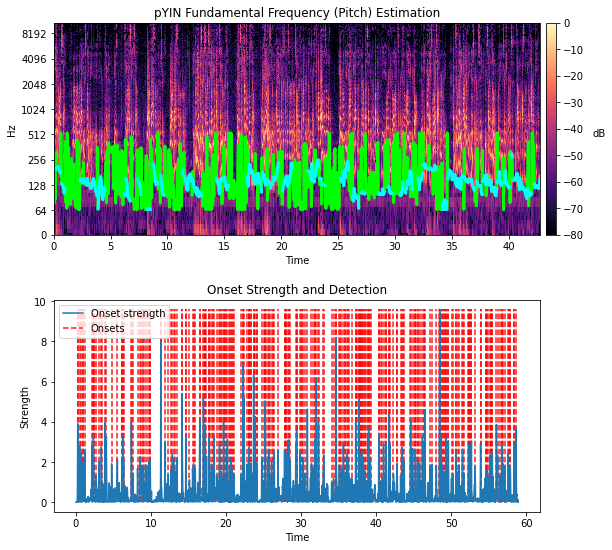

In [8]:
# Pitch
f0, voiced_flag, voiced_probs = librosa.pyin(
    clip, fmin=librosa.note_to_hz("C2"), fmax=librosa.note_to_hz("C5"), sr=wav_sr
)
times = librosa.times_like(f0)
D = librosa.amplitude_to_db(np.abs(librosa.stft(clip)), ref=np.max)
yin_f0 = librosa.yin(
    clip, fmin=librosa.note_to_hz("C2"), fmax=librosa.note_to_hz("C5"), sr=wav_sr
)

# Onset
o_env = librosa.onset.onset_strength(clip, sr=wav_sr, max_size=10)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=wav_sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=wav_sr)

spec_o_env = librosa.onset.onset_strength(clip, sr=wav_sr, max_size=1)
spec_times = librosa.frames_to_time(np.arange(len(spec_o_env)), sr=wav_sr)
spec_onset_frames = librosa.onset.onset_detect(onset_envelope=spec_o_env, sr=wav_sr)


# Plot
D = np.abs(librosa.stft(clip))


fig = plt.figure(figsize=(9, 9))
ax1 = plt.subplot(111)
im1 = librosa.display.specshow(
    librosa.amplitude_to_db(D, ref=np.max),
    x_axis="time",
    y_axis="log",
    ax=ax1,
    label="_nolegend_",
)
ax1.set(title="pYIN Fundamental Frequency (Pitch) Estimation")
(yin_f0_plot,) = ax1.plot(times, yin_f0, color="lime", label="f0 (Pitch)", linewidth=3)

(f0_plot,) = ax1.plot(times, f0, color="cyan", label="f0 (Pitch)", linewidth=3)

# ax1.legend(handles=[f0_plot])

divider = make_axes_locatable(ax1)
ax2 = divider.append_axes("bottom", size="100%", pad=0.9)
cax = divider.append_axes("right", size="2%", pad=0.08)
cb = plt.colorbar(im1, ax=ax1, cax=cax)
cax.get_yaxis().labelpad = 15
cax.set_ylabel("dB", rotation=0)

ax2.set(xlabel="Time", ylabel="Strength", title="Onset Strength and Detection")
ax2.plot(times, o_env, label="Onset strength")
ax2.vlines(
    times[onset_frames],
    0,
    o_env.max(),
    color="r",
    alpha=0.9,
    linestyle="--",
    label="Onsets",
)
ax2.legend()

Text(0.5, 1.0, 'Fundamental Frequency Estimates')

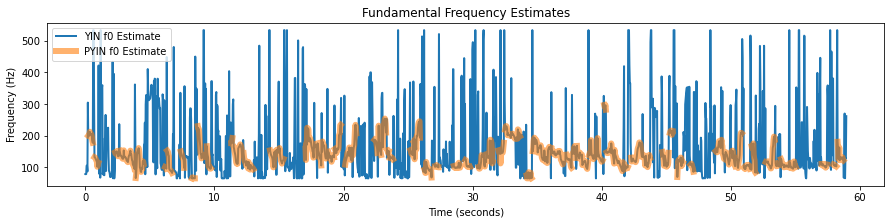

In [9]:
(yin_f0_plot,) = ax1.plot(times, yin_f0, color="lime", label="f0 (Pitch)", linewidth=3)
(f0_plot,) = ax1.plot(
    times,
    f0,
    color="cyan",
    label="f0 (Pitch)",
    linewidth=3,
)

plt.figure(figsize=(15, 3))
plt.plot(times, yin_f0, label="YIN f0 Estimate", linewidth=2)
plt.plot(times, f0, label="PYIN f0 Estimate", linewidth=6, alpha=0.6)
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.legend()
plt.title("Fundamental Frequency Estimates")

In [12]:
sample_1 = dict(a_sample.iloc[1])
wav_file, wav_sr = librosa.load(
    path=osp.join(wavs_dir, f"{sample_1['file']}.wav"),
    sr=librosa.core.get_samplerate(osp.join(wavs_dir, f"{sample_1['file']}.wav")),
)

print("Speaker:", sample_1["speaker"])
print("File - Line", sample_1["file"], "-", sample_1["line"])
print("Duration:", sample_1["duration"])
print("Text:", sample_1["text"])
start_idx = math.floor(wav_sr * sample_1["start"])
end_idx = math.ceil(wav_sr * sample_1["end"])
clip = wav_file[start_idx:end_idx]
play_audio(clip, wav_sr)

Speaker: Antonin_Scalia
File - Line 12-682 - 109
Duration: 26.985
Text: Why -- why doesn't the Fourth Amendment violate the rule you're saying -- or the 14th Amendment violate the rule that you're proposing? I mean, I'm a minority and I want laws that favor my minority. Not just in university; everywhere. My goodness, I can't have that through the normal legislative process. I have to get a constitutional amendment to do it, right?


C:\Users\yagne\.conda\envs\grandstanding\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


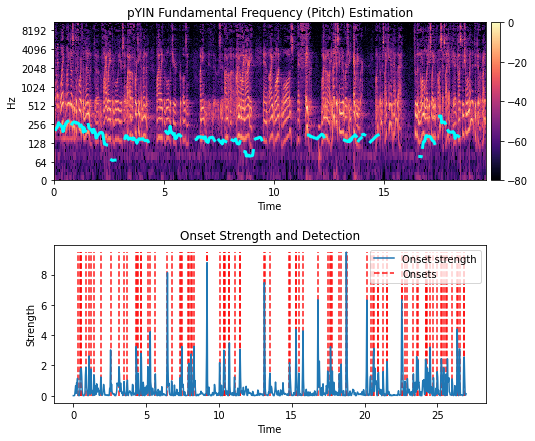

In [13]:
# Pitch
f0, voiced_flag, voiced_probs = librosa.pyin(
    clip, fmin=librosa.note_to_hz("C2"), fmax=librosa.note_to_hz("C5")
)
times = librosa.times_like(f0)
D = librosa.amplitude_to_db(np.abs(librosa.stft(clip)), ref=np.max)

# Onset
o_env = librosa.onset.onset_strength(clip, sr=wav_sr, max_size=10)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=wav_sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=wav_sr)


# Plot
D = np.abs(librosa.stft(clip))


fig = plt.figure(figsize=(8, 7))
ax1 = plt.subplot(111)
im1 = librosa.display.specshow(
    librosa.amplitude_to_db(D, ref=np.max),
    x_axis="time",
    y_axis="log",
    ax=ax1,
    label="_nolegend_",
)
ax1.set(title="pYIN Fundamental Frequency (Pitch) Estimation")
(f0_plot,) = ax1.plot(times, f0, color="cyan", label="f0 (Pitch)", linewidth=3)
# ax1.legend(handles=[f0_plot])

divider = make_axes_locatable(ax1)
ax2 = divider.append_axes("bottom", size="100%", pad=0.9)
cax = divider.append_axes("right", size="2%", pad=0.08)
cb = plt.colorbar(im1, ax=ax1, cax=cax)

ax2.set(xlabel="Time", ylabel="Strength", title="Onset Strength and Detection")
ax2.plot(times, o_env, label="Onset strength")
ax2.vlines(
    times[onset_frames],
    0,
    o_env.max(),
    color="r",
    alpha=0.9,
    linestyle="--",
    label="Onsets",
)
ax2.legend()

In [14]:
sample_1 = dict(a_sample.iloc[2])
wav_file, wav_sr = librosa.load(
    path=osp.join(wavs_dir, f"{sample_1['file']}.wav"),
    sr=librosa.core.get_samplerate(osp.join(wavs_dir, f"{sample_1['file']}.wav")),
)

print("Speaker:", sample_1["speaker"])
print("File - Line", sample_1["file"], "-", sample_1["line"])
print("Duration:", sample_1["duration"])
print("Text:", sample_1["text"])
start_idx = math.floor(wav_sr * sample_1["start"])
end_idx = math.ceil(wav_sr * sample_1["end"])
clip = wav_file[start_idx:end_idx]
play_audio(clip, wav_sr)

Speaker: Sonia_Sotomayor
File - Line 12-682 - 6
Duration: 13.66
Text: I thought that in Grutter, all of the social scientists had pointed out to the fact that all of those efforts had failed. That's one of the reasons why the -- I think it was a law school claim in Michigan was upheld.


C:\Users\yagne\.conda\envs\grandstanding\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


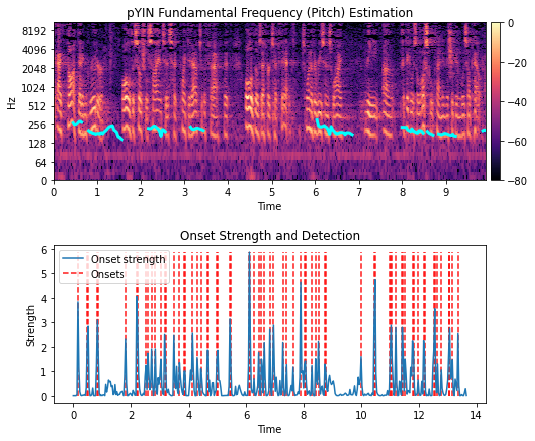

In [15]:
# Pitch
f0, voiced_flag, voiced_probs = librosa.pyin(
    clip, fmin=librosa.note_to_hz("C2"), fmax=librosa.note_to_hz("C5")
)
times = librosa.times_like(f0)
D = librosa.amplitude_to_db(np.abs(librosa.stft(clip)), ref=np.max)

# Onset
o_env = librosa.onset.onset_strength(clip, sr=wav_sr, max_size=10)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=wav_sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=wav_sr)


# Plot
D = np.abs(librosa.stft(clip))


fig = plt.figure(figsize=(8, 7))
ax1 = plt.subplot(111)
im1 = librosa.display.specshow(
    librosa.amplitude_to_db(D, ref=np.max),
    x_axis="time",
    y_axis="log",
    ax=ax1,
    label="_nolegend_",
)
ax1.set(title="pYIN Fundamental Frequency (Pitch) Estimation")
(f0_plot,) = ax1.plot(times, f0, color="cyan", label="f0 (Pitch)", linewidth=3)
# ax1.legend(handles=[f0_plot])

divider = make_axes_locatable(ax1)
ax2 = divider.append_axes("bottom", size="100%", pad=0.9)
cax = divider.append_axes("right", size="2%", pad=0.08)
cb = plt.colorbar(im1, ax=ax1, cax=cax)

ax2.set(xlabel="Time", ylabel="Strength", title="Onset Strength and Detection")
ax2.plot(times, o_env, label="Onset strength")
ax2.vlines(
    times[onset_frames],
    0,
    o_env.max(),
    color="r",
    alpha=0.9,
    linestyle="--",
    label="Onsets",
)
ax2.legend()

In [16]:
sample_1 = dict(a_sample.iloc[3])
wav_file, wav_sr = librosa.load(
    path=osp.join(wavs_dir, f"{sample_1['file']}.wav"),
    sr=librosa.core.get_samplerate(osp.join(wavs_dir, f"{sample_1['file']}.wav")),
)

print("Speaker:", sample_1["speaker"])
print("File - Line", sample_1["file"], "-", sample_1["line"])
print("Duration:", sample_1["duration"])
print("Text:", sample_1["text"])
start_idx = math.floor(wav_sr * sample_1["start"])
end_idx = math.ceil(wav_sr * sample_1["end"])
clip = wav_file[start_idx:end_idx]
play_audio(clip, wav_sr)

Speaker: Sonia_Sotomayor
File - Line 12-682 - 33
Duration: 21.831
Text: But I don't see how the argument would be any different here. One of the main sponsors of this bill said it was intended to segregate again. The voters in Seattle were not all filled with animus; some of them just cared about their children not leaving -- not having outsiders come in. I mean, there's always voters who have good intent.


C:\Users\yagne\.conda\envs\grandstanding\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


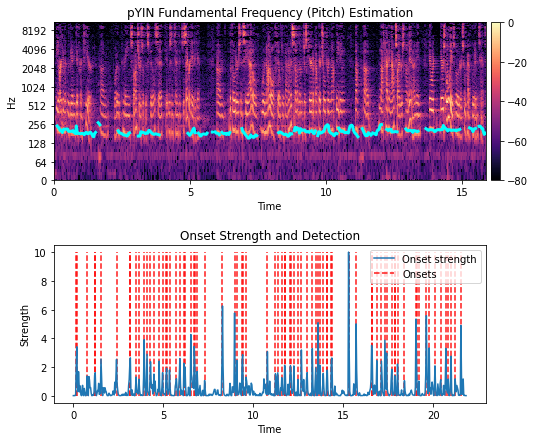

In [17]:
# Pitch
f0, voiced_flag, voiced_probs = librosa.pyin(
    clip, fmin=librosa.note_to_hz("C2"), fmax=librosa.note_to_hz("C5")
)
times = librosa.times_like(f0)
D = librosa.amplitude_to_db(np.abs(librosa.stft(clip)), ref=np.max)

# Onset
o_env = librosa.onset.onset_strength(clip, sr=wav_sr, max_size=10)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=wav_sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=wav_sr)


# Plot
D = np.abs(librosa.stft(clip))


fig = plt.figure(figsize=(8, 7))
ax1 = plt.subplot(111)
im1 = librosa.display.specshow(
    librosa.amplitude_to_db(D, ref=np.max),
    x_axis="time",
    y_axis="log",
    ax=ax1,
    label="_nolegend_",
)
ax1.set(title="pYIN Fundamental Frequency (Pitch) Estimation")
(f0_plot,) = ax1.plot(times, f0, color="cyan", label="f0 (Pitch)", linewidth=3)

divider = make_axes_locatable(ax1)
ax2 = divider.append_axes("bottom", size="100%", pad=0.9)
cax = divider.append_axes("right", size="2%", pad=0.08)
cb = plt.colorbar(im1, ax=ax1, cax=cax)

ax2.set(xlabel="Time", ylabel="Strength", title="Onset Strength and Detection")
ax2.plot(times, o_env, label="Onset strength")
ax2.vlines(
    times[onset_frames],
    0,
    o_env.max(),
    color="r",
    alpha=0.9,
    linestyle="--",
    label="Onsets",
)
ax2.legend()

In [18]:
sample_1 = dict(a_sample.iloc[4])
wav_file, wav_sr = librosa.load(
    path=osp.join(wavs_dir, f"{sample_1['file']}.wav"),
    sr=librosa.core.get_samplerate(osp.join(wavs_dir, f"{sample_1['file']}.wav")),
)

print("Speaker:", sample_1["speaker"])
print("File - Line", sample_1["file"], "-", sample_1["line"])
print("Duration:", sample_1["duration"])
print("Text:", sample_1["text"])
start_idx = math.floor(wav_sr * sample_1["start"])
end_idx = math.ceil(wav_sr * sample_1["end"])
clip = wav_file[start_idx:end_idx]
play_audio(clip, wav_sr)

Speaker: Elena_Kagan
File - Line 12-138 - 105
Duration: 16.277
Text: Mr. Blackman, can I just ask you to assume for a second that that's not so. If you had -- if BG and the Republic of Argentina had itself entered into this agreement, would you agree that this is a typical Howsam kind of provision?


C:\Users\yagne\.conda\envs\grandstanding\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


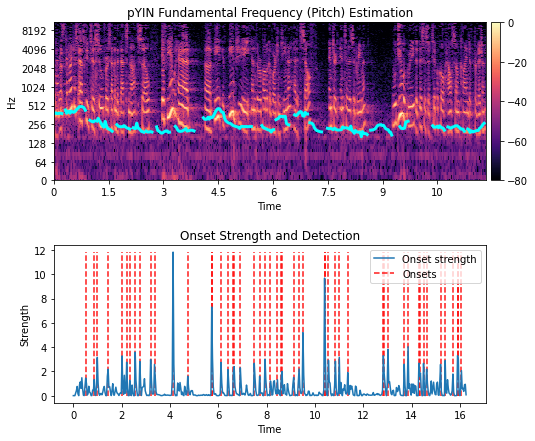

In [19]:
# Pitch
f0, voiced_flag, voiced_probs = librosa.pyin(
    clip, fmin=librosa.note_to_hz("C2"), fmax=librosa.note_to_hz("C5")
)
times = librosa.times_like(f0)
D = librosa.amplitude_to_db(np.abs(librosa.stft(clip)), ref=np.max)

# Onset
o_env = librosa.onset.onset_strength(clip, sr=wav_sr, max_size=10)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=wav_sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=wav_sr)


# Plot
D = np.abs(librosa.stft(clip))


fig = plt.figure(figsize=(8, 7))
ax1 = plt.subplot(111)
im1 = librosa.display.specshow(
    librosa.amplitude_to_db(D, ref=np.max),
    x_axis="time",
    y_axis="log",
    ax=ax1,
    label="_nolegend_",
)
ax1.set(title="pYIN Fundamental Frequency (Pitch) Estimation")
(f0_plot,) = ax1.plot(times, f0, color="cyan", label="f0 (Pitch)", linewidth=3)
# ax1.legend(handles=[f0_plot])

divider = make_axes_locatable(ax1)
ax2 = divider.append_axes("bottom", size="100%", pad=0.9)
cax = divider.append_axes("right", size="2%", pad=0.08)
cb = plt.colorbar(im1, ax=ax1, cax=cax)

ax2.set(xlabel="Time", ylabel="Strength", title="Onset Strength and Detection")
ax2.plot(times, o_env, label="Onset strength")
ax2.vlines(
    times[onset_frames],
    0,
    o_env.max(),
    color="r",
    alpha=0.9,
    linestyle="--",
    label="Onsets",
)
ax2.legend()